In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
import os

In [12]:
data_dir = '/content/drive/MyDrive/Weather_classification/Data'  # Replace with your data directory path
train_data_dir = os.path.join(data_dir, 'train')
val_data_dir = os.path.join(data_dir, 'val')
best_model_path = '/content/drive/MyDrive/Weather_classification/best_model.h5'  # Define the path to save the best model



In [13]:
def prepare_data_generators(data_dir, val_data_dir, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    val_generator = datagen.flow_from_directory(
        val_data_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    return train_generator, val_generator


In [14]:
def create_model(learning_rate, num_neurons):
    # Load the pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers except the last 4 layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(num_neurons, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(11, activation='softmax')(x)  # Assuming 11 classes

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# use diffrent lr and num_neurons and apply k-fold

# Hyperparameter space
learning_rates = [0.01, 0.001, 0.0001]
num_neurons = [512, 1024]

num_folds = 5
best_accuracy = 0
best_lr = 0
best_neuron = 0

for lr in learning_rates:
    for neuron in num_neurons:
        fold_accuracies = []

        for fold in range(num_folds):
            print(f"Training on fold {fold + 1}/{num_folds}...")

            # Prepare data generators for the current fold
            train_generator, val_generator = prepare_data_generators(train_data_dir, val_data_dir)

            # Create the model
            model = create_model(lr, neuron)

            # Train the model
            history = model.fit(
                train_generator,
                epochs=10,
                validation_data=val_generator
            )

            # Evaluate the model
            accuracy = model.evaluate(val_generator)[1]
            fold_accuracies.append(accuracy)
            print("lr", lr, "neuron", neuron, "fold", fold, "accuracy", accuracy)

        # Average accuracy for current hyperparameters
        avg_accuracy = np.mean(fold_accuracies)
        print("avg_accuracy", avg_accuracy)

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_lr = lr
            best_neuron = neuron
            model.save(best_model_path)

print(f'Best Accuracy: {best_accuracy}, Best Learning Rate: {best_lr}, Best Number of Neurons: {best_neuron}')


Training on fold 1/5...
Found 4745 images belonging to 11 classes.
Found 676 images belonging to 11 classes.
Epoch 1/10
149/149 [==============================] - 1573s 11s/step - loss: 1.4363 - accuracy: 0.5123 - val_loss: 0.7805 - val_accuracy: 0.7219
Epoch 2/10
149/149 [==============================] - 24s 161ms/step - loss: 0.7109 - accuracy: 0.7488 - val_loss: 0.5998 - val_accuracy: 0.7988
Epoch 3/10
149/149 [==============================] - 24s 162ms/step - loss: 0.4962 - accuracy: 0.8238 - val_loss: 0.6231 - val_accuracy: 0.7692
Epoch 4/10
149/149 [==============================] - 27s 181ms/step - loss: 0.3997 - accuracy: 0.8590 - val_loss: 0.4748 - val_accuracy: 0.8284
Epoch 5/10
149/149 [==============================] - 27s 180ms/step - loss: 0.3164 - accuracy: 0.8972 - val_loss: 0.4794 - val_accuracy: 0.8432
Epoch 6/10
149/149 [==============================] - 27s 183ms/step - loss: 0.2396 - accuracy: 0.9184 - val_loss: 0.5095 - val_accuracy: 0.8536
Epoch 7/10
149/149 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training on fold 1/5...
Found 4745 images belonging to 11 classes.
Found 676 images belonging to 11 classes.
Epoch 1/10
149/149 [==============================] - 27s 174ms/step - loss: 1.3792 - accuracy: 0.5361 - val_loss: 0.7434 - val_accuracy: 0.7234
Epoch 2/10
149/149 [==============================] - 26s 176ms/step - loss: 0.6806 - accuracy: 0.7572 - val_loss: 0.6101 - val_accuracy: 0.7870
Epoch 3/10
149/149 [==============================] - 26s 173ms/step - loss: 0.4703 - accuracy: 0.8301 - val_loss: 0.4948 - val_accuracy: 0.8358
Epoch 4/10
149/149 [==============================] - 26s 176ms/step - loss: 0.3445 - accuracy: 0.8761 - val_loss: 0.4450 - val_accuracy: 0.8536
Epoch 5/10
149/149 [==============================] - 26s 171ms/step - loss: 0.3120 - accuracy: 0.8974 - val_loss: 0.4566 - val_accuracy: 0.8550
Epoch 6/10
149/149 [==============================] - 28s 189ms/step - loss: 0.1968 - accuracy: 0.9359 - val_loss: 0.5098 - val_accuracy: 0.8476
Epoch 7/10
149/149 [=

In [15]:
# now we can train the model using lr=0.01 and neuron=1024
# also we use number of ebochs=30

lr=0.01
neuron=1024
num_ebochs=30

train_generator, val_generator = prepare_data_generators(train_data_dir, val_data_dir)

# Create the model
model = create_model(lr, neuron)

# Train the model
history = model.fit(
    train_generator,
    epochs=num_ebochs,
    validation_data=val_generator
)

# Evaluate the model
accuracy = model.evaluate(val_generator)[1]
model.save(best_model_path)
print("accuracy", accuracy)

Found 4111 images belonging to 11 classes.
Found 661 images belonging to 11 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
129/129 [==============================] - 1535s 12s/step - loss: 1.4709 - accuracy: 0.5074 - val_loss: 0.7978 - val_accuracy: 0.7095
Epoch 2/30
129/129 [==============================] - 24s 182ms/step - loss: 0.6908 - accuracy: 0.7587 - val_loss: 0.8995 - val_accuracy: 0.6989
Epoch 3/30
129/129 [==============================] - 25s 193ms/step - loss: 0.4869 - accuracy: 0.8292 - val_loss: 0.5285 - val_accuracy: 0.8018
Epoch 4/30
129/129 [==============================] - 24s 186ms/step - loss: 0.3552 - accuracy: 0.8772 - val_loss: 0.5249 - val_accuracy: 0.8215
Epoch 5/30
129/129 [==============================] - 25s 192ms/step - loss: 0.2617 - accuracy: 0.9093 - val_loss: 0.6136 - val_accuracy: 0.8094
Epoch 6/30
129/129 [==============================] - 24s 187ms/step - loss: 0.1994 - accuracy: 0.9348 - val_loss: 0.5833 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


accuracy 0.8729197978973389


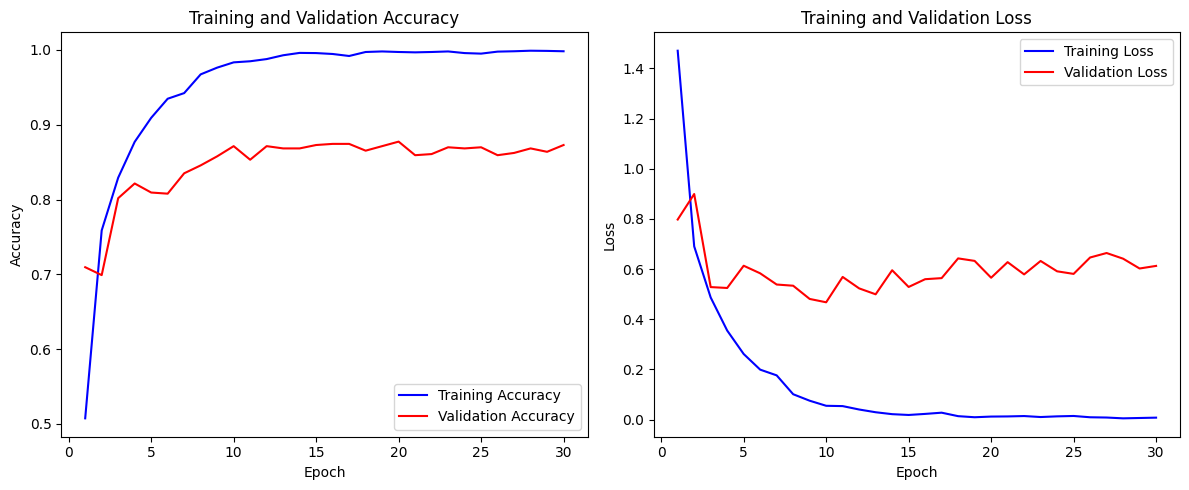

In [16]:
import matplotlib.pyplot as plt
# Extracting the metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, num_ebochs + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
best_model = tf.keras.models.load_model(best_model_path)

test_data_dir = os.path.join(data_dir, 'test')  # Replace with your test data directory path

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # Set shuffle to False for consistent results

# test_loss, test_accuracy = best_model.evaluate(test_generator)
# print(f'Test Accuracy: {test_accuracy}')



Found 1365 images belonging to 11 classes.


In [18]:
# Make predictions
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

43/43 [==============================] - 394s 9s/step


In [19]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


In [20]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=class_labels))


              precision    recall  f1-score   support

         dew       0.94      0.95      0.95       140
     fogsmog       0.87      0.92      0.90       168
       frost       0.81      0.77      0.79        96
       glaze       0.81      0.75      0.78       128
        hail       0.93      0.97      0.95       116
   lightning       1.00      0.99      0.99        75
        rain       0.86      0.92      0.89       104
     rainbow       0.94      0.94      0.94        48
        rime       0.85      0.88      0.86       232
   sandstorm       0.94      0.86      0.90       136
        snow       0.78      0.73      0.75       122

    accuracy                           0.88      1365
   macro avg       0.88      0.88      0.88      1365
weighted avg       0.88      0.88      0.88      1365



In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
